In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score



# Notebook with EDA and process to Model Selection

## 1) EDA

The goal of the EDA is:
- look for any missing values in the data set
- look for eventual error measurements to be deleted or corrected (we dont necessarily pay very much attention to outliers because they are going to be many for a data set of this size)
- look which predictor variables might be useful to predict bike count 

Before starting the EDA, we remind the reader that the target variable (ie what we are trying to predict is the variable `log_bike_count`

We first import the original data, set check for missing values and error measurements and then merge it with the external and check no data was lost in the process

In [2]:
pd.set_option("display.precision", 2)  # set precision of outputs of our df

# read the data
df_original = pd.read_parquet(Path("data") / "train.parquet")
df_original.head()


,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.85,2.38,0.00
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.85,2.38,0.69
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.85,2.38,0.00
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.85,2.38,1.61
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.85,2.38,2.30


In [3]:
df_original.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 455163 entries, 48321 to 928462
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 455163 non-null  category      
 1   counter_name               455163 non-null  category      
 2   site_id                    455163 non-null  int64         
 3   site_name                  455163 non-null  category      
 4   bike_count                 455163 non-null  float64       
 5   date                       455163 non-null  datetime64[ns]
 6   counter_installation_date  455163 non-null  datetime64[ns]
 7   counter_technical_id       455163 non-null  category      
 8   latitude                   455163 non-null  float64       
 9   longitude                  455163 non-null  float64       
 10  log_bike_count             455163 non-null  float64       
dtypes: category(4), datetime64[ns](2), float64(4), i

In [4]:
df_original.describe()


,site_id,bike_count,latitude,longitude,log_bike_count
count,4.55e+05,455163.00,455163.00,455163.00,455163.00
mean,1.05e+08,59.48,48.85,2.35,3.05
std,3.16e+07,87.13,0.02,0.04,1.68
min,1.00e+08,0.00,48.83,2.27,0.00
25%,1.00e+08,4.00,48.84,2.31,1.61
50%,1.00e+08,28.00,48.85,2.35,3.37
75%,1.00e+08,79.00,48.86,2.38,4.38
max,3.00e+08,1275.00,48.89,2.41,7.15


There are 455 163 observations in the training data set and 9 predictor variables. However some of them like `site_name` and `site_id`, or `counter_name` and `counter_id` are redundant and both should not be included in the model. Also,  `site_id` is an int so we should remember it is a categorical variable if we want to use it in our model. <br>
Finally, there are no missing values. 
Let us now perform the merge and check how is the df.

In [73]:
file_path = Path("data") / "external_data.csv"
df_ext = pd.read_csv(file_path, parse_dates=["date"])


In [77]:
#df_ext.to_csv(file_path)

In [6]:
df_ext.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,numer_sta,date,pmer,tend,cod_tend,dd,ff,...,ctype3,hnuage3,nnuage4,ctype4,hnuage4,hol_scol,hol_bank,quarantine1,quarantine2,christmas_hols
0,0,0,0,7149,2021-01-01 00:00:00,100810,80,1,270,1.8,...,NaN,NaN,NaN,NaN,NaN,True,True,False,False,True
1,1,1,1,7149,2021-01-01 03:00:00,100920,110,3,300,1.7,...,NaN,NaN,NaN,NaN,NaN,True,True,False,False,True
2,2,2,2,7149,2021-01-01 06:00:00,100950,30,3,290,2.6,...,3.0,3000.0,NaN,NaN,NaN,True,True,False,False,True
3,3,3,3,7149,2021-01-01 09:00:00,101100,150,2,280,1.7,...,NaN,NaN,NaN,NaN,NaN,True,True,False,False,True
4,4,4,4,7149,2021-01-01 12:00:00,101110,30,0,50,1.0,...,6.0,810.0,NaN,NaN,NaN,True,True,False,False,True


In [7]:
np.unique(df_ext["numer_sta"])

array([7149])

The weather data comes from one unique station, therefore this column is not needed we can drop it. <br>
The weather station is located in the southern part of Paris (Orly) so the weather data is relevant for Paris.

In [8]:
# remove some unecessary columns
df_ext = df_ext.iloc[:,3:]

From the head, we already see that some columns seem to have a lot of missing values. We investigate this further. We also check first if there are duplicate rows and if any dates are missing.

In [9]:
df_ext[df_ext.duplicated()==True] 

,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,u,...,ctype3,hnuage3,nnuage4,ctype4,hnuage4,hol_scol,hol_bank,quarantine1,quarantine2,christmas_hols
2018,7149,2020-11-20 18:00:00,103650,20,2,180,1.0,278.15,276.45,89,...,NaN,NaN,NaN,NaN,NaN,False,False,True,False,False


In [10]:
my_range = pd.date_range(
  start="2020-09-01", end="2021-10-18")

print(my_range.difference(df_ext['date']))

DatetimeIndex(['2021-01-17'], dtype='datetime64[ns]', freq=None)


One day is missing in the data set.

There is one duplicate row, we drop it.

In [11]:
df_ext = df_ext.drop_duplicates()

In [12]:
df_ext.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3321
Data columns (total 64 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   numer_sta       3321 non-null   int64         
 1   date            3321 non-null   datetime64[ns]
 2   pmer            3321 non-null   int64         
 3   tend            3321 non-null   int64         
 4   cod_tend        3321 non-null   int64         
 5   dd              3321 non-null   int64         
 6   ff              3321 non-null   float64       
 7   t               3321 non-null   float64       
 8   td              3321 non-null   float64       
 9   u               3321 non-null   int64         
 10  vv              3321 non-null   int64         
 11  ww              3321 non-null   int64         
 12  w1              3314 non-null   float64       
 13  w2              3311 non-null   float64       
 14  n               3165 non-null   float64       
 15  nbas

In [13]:
print(df_ext.isnull().sum()[df_ext.isnull().sum() > 0])
print(
    f"there are {df_ext.isnull().sum()[df_ext.isnull().sum()>0].shape[0]} columns with at least 1 missing values ")

w1              7
w2             10
n             156
nbas            5
hbas          453
cl            413
cm           1381
ch           1644
niv_bar      3321
geop         3321
tend24         10
tn12         2492
tn24         3321
tx12         2492
tx24         3321
tminsol      3320
sw           3321
tw           3321
raf10          10
etat_sol       52
ht_neige       49
ssfrai        445
perssfrai     445
rr1             9
rr3             6
rr6            16
rr12           22
rr24           24
phenspe1     3321
phenspe2     3321
phenspe3     3321
phenspe4     3321
nnuage1       449
ctype1        798
hnuage1       455
nnuage2      1626
ctype2       1878
hnuage2      1626
nnuage3      2703
ctype3       2851
hnuage3      2703
nnuage4      3279
ctype4       3234
hnuage4      3279
dtype: int64
there are 44 columns with at least 1 missing values 


We have 44 columns with missing values.

Hence, we see that most columns have missing values and from the output, some columns have no non NA values! <br>
We drop the columns that have more than 10% missing values first as we are unlikely to be able to get interesting predictions with that little amount of data.


In [14]:
n_rows = df_ext.shape[0]

columns_to_drop = (df_ext.isnull().sum()/n_rows)[(df_ext.isnull().sum()/n_rows) > 0.1].index

df_ext = df_ext.drop(columns=columns_to_drop)



Let us check now the missing values again.

In [15]:
#df_merge_ext[df_merge_ext.isnull().sum()>0]
col_with_miss_values = df_ext.isnull().sum()[df_ext.isnull().sum() > 0].index
print(col_with_miss_values)

Index(['w1', 'w2', 'n', 'nbas', 'tend24', 'raf10', 'etat_sol', 'ht_neige',
       'rr1', 'rr3', 'rr6', 'rr12', 'rr24'],
      dtype='object')


There are 13 columns with missing values. How are these values missing, are they MCAR, MAR, or is there any pattern in the missing values?


We plot the missing values against time.

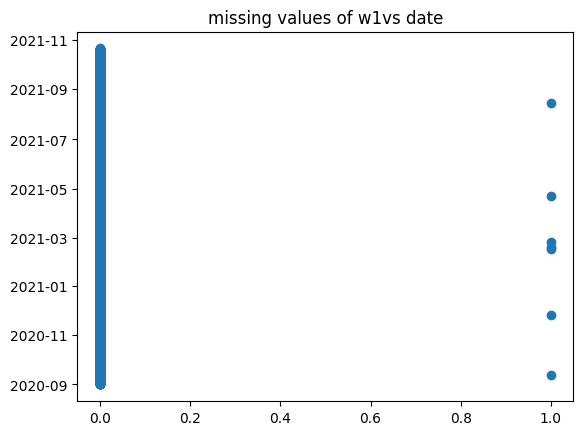

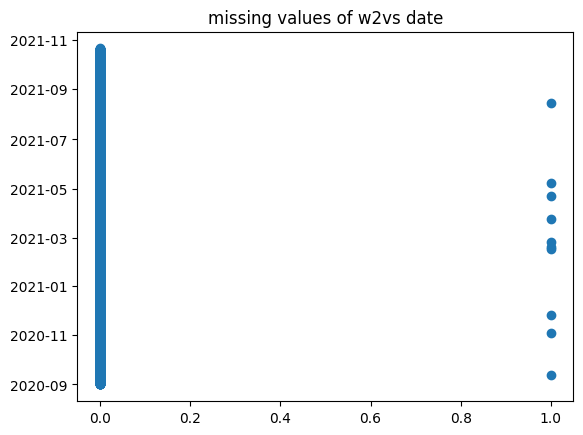

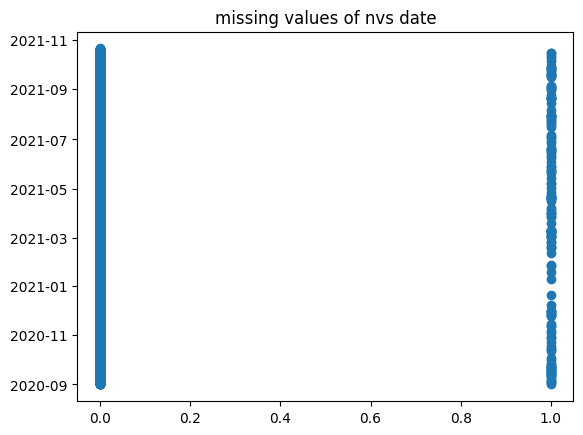

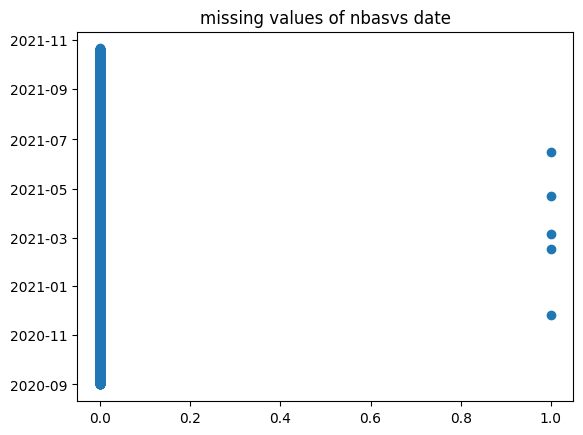

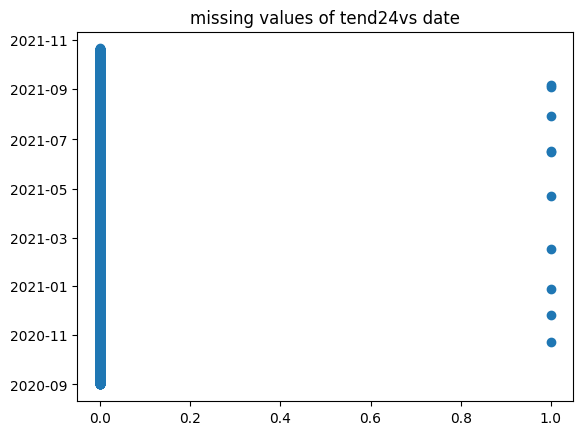

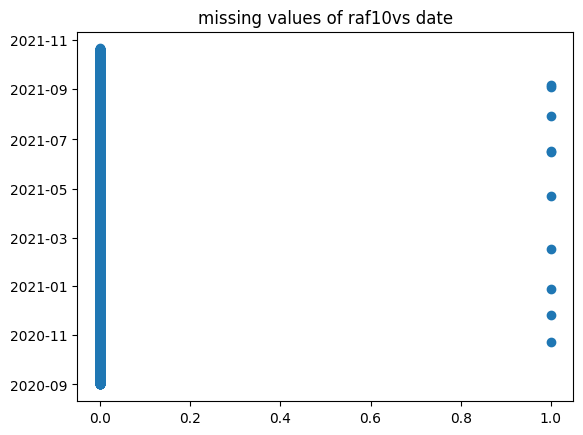

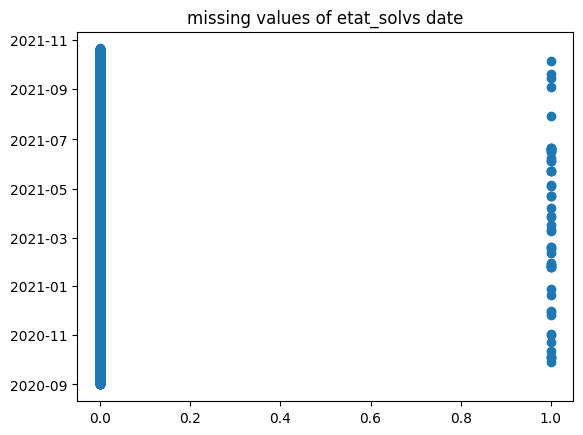

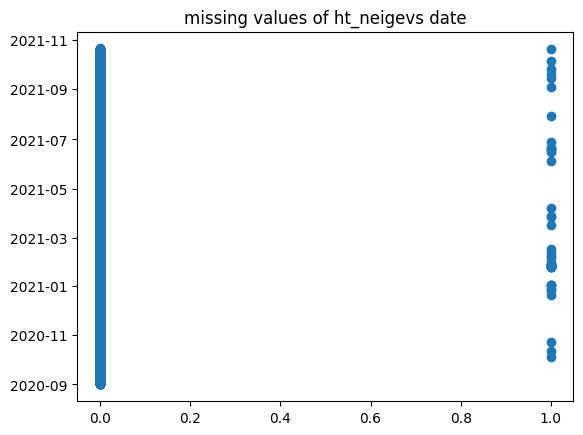

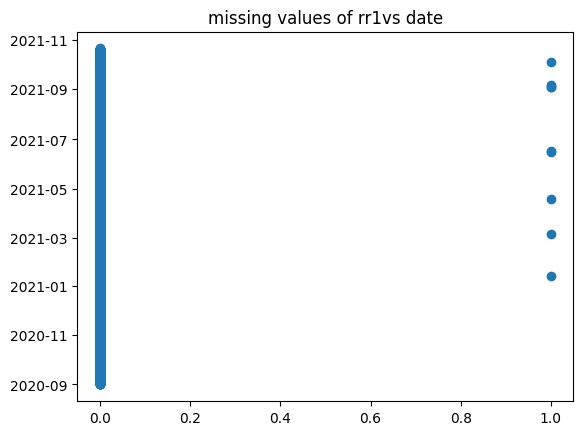

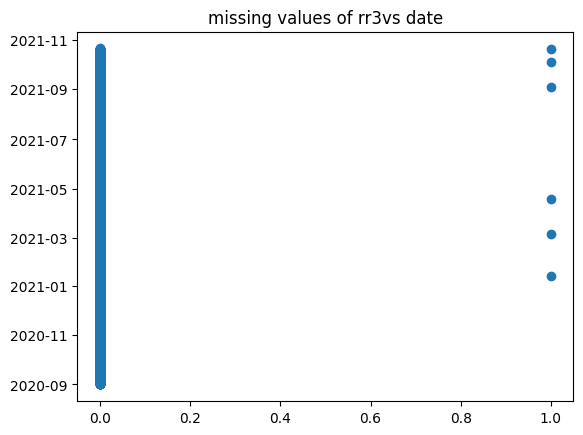

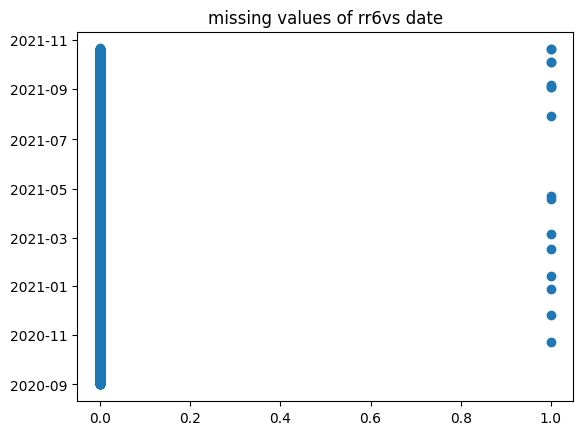

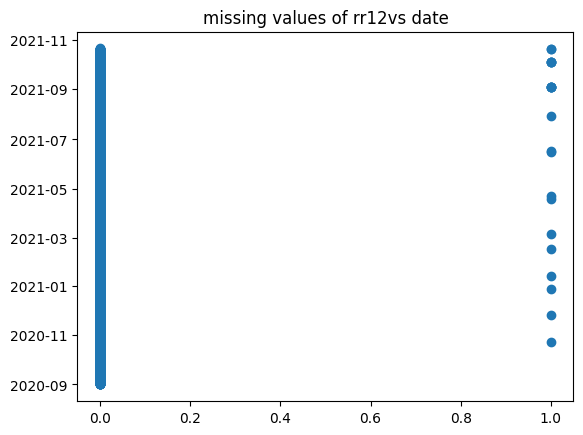

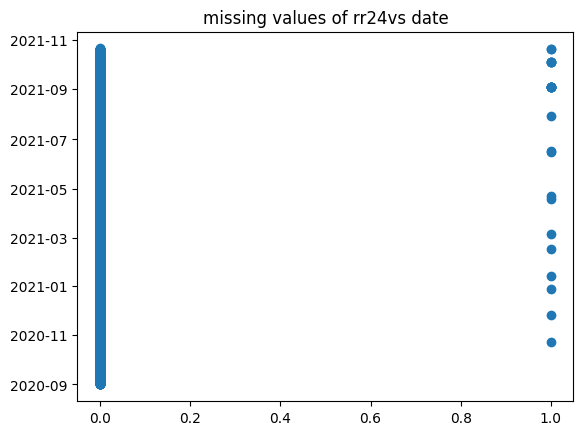

In [16]:
for el in col_with_miss_values:
    plt.scatter(df_ext[el].isnull(),df_ext["date"])
    plt.title("missing values of " + el + "vs date")
    plt.show()

In [17]:
df_ext.isnull().sum()[df_ext.isnull().sum()>0]

w1            7
w2           10
n           156
nbas          5
tend24       10
raf10        10
etat_sol     52
ht_neige     49
rr1           9
rr3           6
rr6          16
rr12         22
rr24         24
dtype: int64

As we have noted that most missing values are not in series we can use linear interpolation to recover the missing values. A limit to fill 4 consecutive NANs is needed to fill all the missing values, however a limit of 1 fills already a lot of the values meaning we don't loose too much weather precision. <br>
In linear interpolation, the estimated point is assumed to lie on the line joining the nearest points to the left and right. <br>
The code variables need to use ffil=pad to not create new codes due to interpolation.

In [18]:
linear_cols = ["n","nbas","tend24","raf10","ht_neige","rr1","rr3","rr6","rr12","rr24"]
for col in linear_cols:
    df_ext[col] = df_ext[col].interpolate(method='linear',limit=4, limit_direction='both', axis=0)
pad_cols = ["w1","w2","etat_sol"]
for col in pad_cols:
    df_ext[col] = df_ext[col].interpolate(method='pad',limit=4, limit_direction='forward', axis=0)

In [19]:
df_ext.isnull().sum()[df_ext.isnull().sum()>0]

Series([], dtype: int64)

In [20]:
# merge on date to obtain the full data set.
df_merge_ext = pd.merge_asof(df_original.sort_values(
    "date"), df_ext.sort_values("date"), on="date")

In [21]:
df_merge_ext.isnull().sum()[df_merge_ext.isnull().sum()>0]

Series([], dtype: int64)

In [22]:
df_merge_ext.columns

Index(['counter_id', 'counter_name', 'site_id', 'site_name', 'bike_count',
       'date', 'counter_installation_date', 'counter_technical_id', 'latitude',
       'longitude', 'log_bike_count', 'numer_sta', 'pmer', 'tend', 'cod_tend',
       'dd', 'ff', 't', 'td', 'u', 'vv', 'ww', 'w1', 'w2', 'n', 'nbas', 'pres',
       'tend24', 'raf10', 'rafper', 'per', 'etat_sol', 'ht_neige', 'rr1',
       'rr3', 'rr6', 'rr12', 'rr24', 'hol_scol', 'hol_bank', 'quarantine1',
       'quarantine2', 'christmas_hols'],
      dtype='object')

Aside from the weather data, boolean features for the school and bank holidays were added as it seems reasonnable to assume a change in bike counts on those days. The Covid quarantine periods were added as well.

### Adding some extra features due to EDA

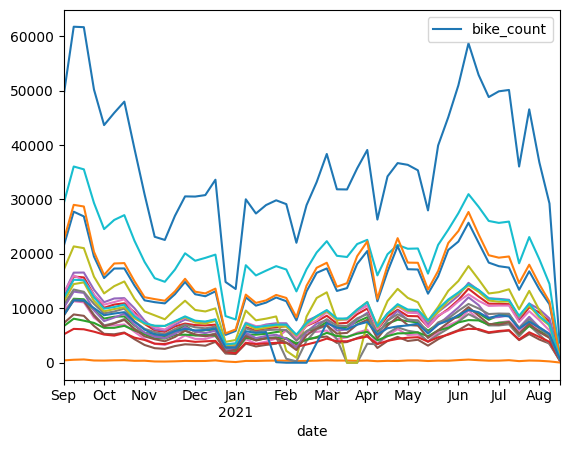

In [23]:
mask = (df_original["counter_name"] == "Totem 73 boulevard de Sébastopol S-N") # & (data["date"] < "2021-01-01") & (data["date"] >= "2021-01-01")
ax = df_original[mask].groupby(pd.Grouper(freq="1w", key="date"))[["bike_count"]].sum().plot()
i=0
for name in df_original["counter_name"].unique().to_list():
    if i == 20:
        break
    i+=1
    mask = (df_original["counter_name"] == name)
    df_original[mask].groupby(pd.Grouper(freq="1w", key="date"))[["bike_count"]].sum().plot(ax =ax, legend=False)

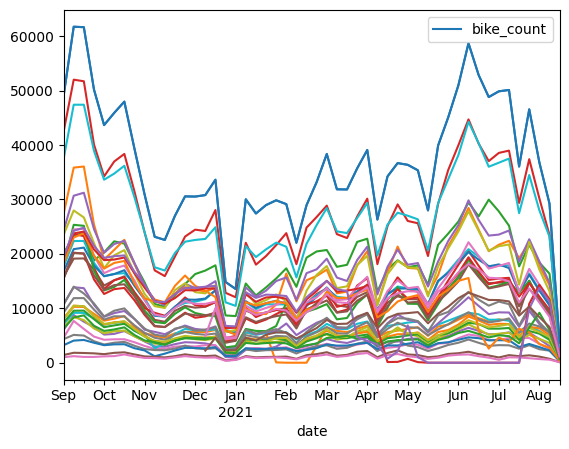

In [24]:
mask = (df_original["counter_name"] == "Totem 73 boulevard de Sébastopol S-N") # & (data["date"] < "2021-01-01") & (data["date"] >= "2021-01-01")
ax = df_original[mask].groupby(pd.Grouper(freq="1w", key="date"))[["bike_count"]].sum().plot()
for i in range(20,len(df_original["counter_name"].unique().to_list())):
    name = df_original["counter_name"].unique().to_list()[i]
    #print(name)
    mask = (df_original["counter_name"] == name)
    df_original[mask].groupby(pd.Grouper(freq="1w", key="date"))[["bike_count"]].sum().plot(ax =ax, legend=False)

By plotting the counts over the weeks we can observe a strong general drop due to the Christmas holiday. We will ad a boolean variable for it.

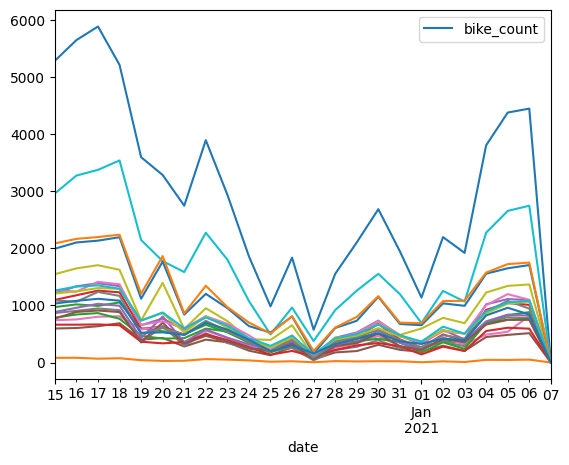

In [25]:
mask = (df_original["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")  & (df_original["date"] >= "2020-12-15") & (df_original["date"] <= "2021-01-07")
ax = df_original[mask].groupby(pd.Grouper(freq="1d", key="date"))[["bike_count"]].sum().plot()
i=0
for name in df_original["counter_name"].unique().to_list():
    if i == 20:
        break
    i+=1
    mask = (df_original["counter_name"] == name) & (df_original["date"] >= "2020-12-15") & (df_original["date"] <= "2021-01-07")
    df_original[mask].groupby(pd.Grouper(freq="1d", key="date"))[["bike_count"]].sum().plot(ax =ax, legend=False)

We can clearly see a trop in the christmas holidays in Paris : samedi 18 décembre 2021 au lundi 3 janvier 2022.

In [26]:
#df_merge_ext["christmas_hols"] = np.where((df_merge_ext["date"] >= "2020-12-18") & (df_merge_ext["date"] < "2021-01-04"), True, False)

In [27]:
#mask = (df_original["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")  & (df_original["date"] >= "2021-02-05") & (df_original["date"] <= "2021-02-20")
#ax = df_original[mask].groupby(pd.Grouper(freq="1d", key="date"))[["bike_count"]].sum().plot()
#i=0
#for name in df_original["counter_name"].unique().to_list():
#    if i == 20:
#        break
#    i+=1
#    mask = (df_original["counter_name"] == name) & (df_original["date"] >= "2021-02-05") & (df_original["date"] <= "2021-02-20")
#    df_original[mask].groupby(pd.Grouper(freq="1d", key="date"))[["bike_count"]].sum().plot(ax =ax, legend=False)

In [28]:
df_predictors = df_merge_ext.iloc[:,11:]
#rename this probably to weather

We focus on one counter only to explore data. Jsp si c'est vrmnt nécessaire ça.

In [29]:
#Totem 73 boulevard de Sébastopol S-N	1809231.0
#Totem 85 quai d'Austerlitz NO-SE	543360.0
#36 quai de Grenelle SO-NE	373227.0
#interesting to check other types of counters or total

/usr/local/anaconda3/envs/bikes-ramp/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3433: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


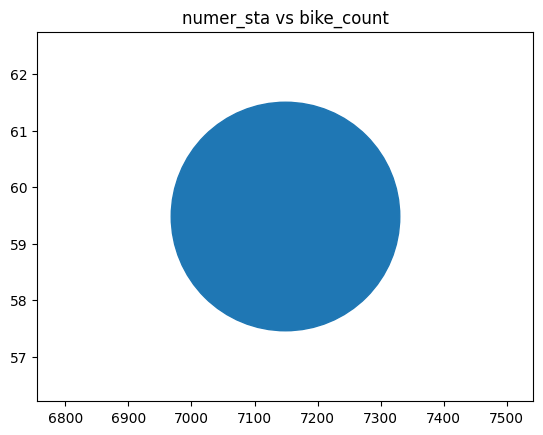

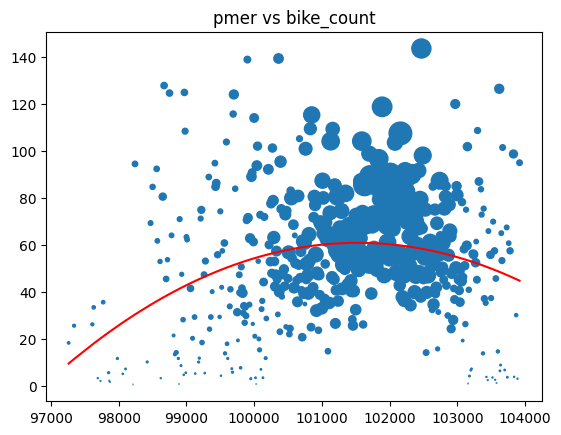

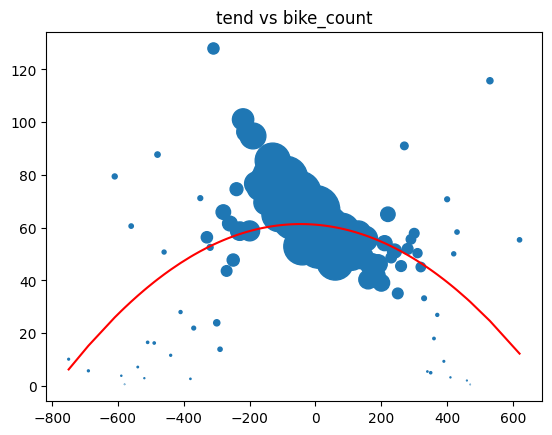

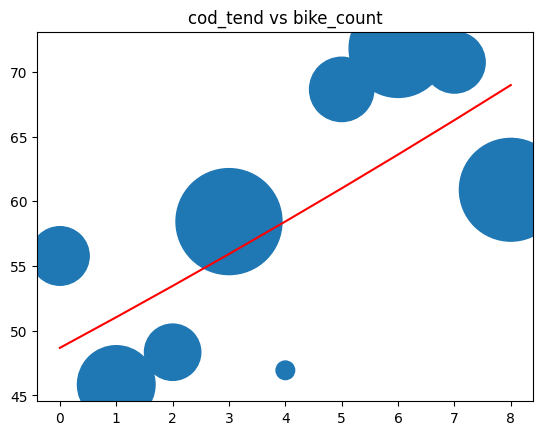

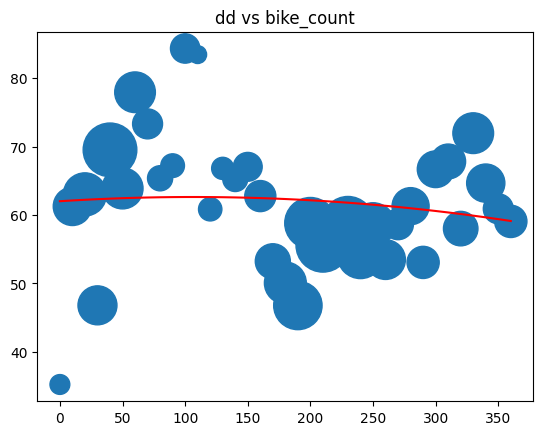

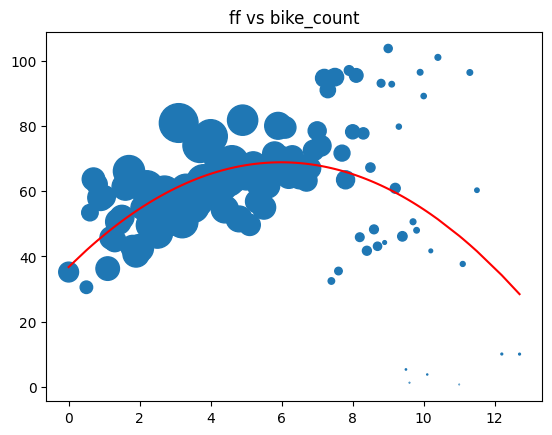

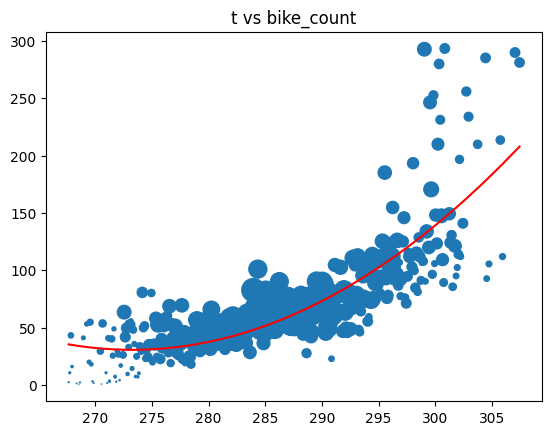

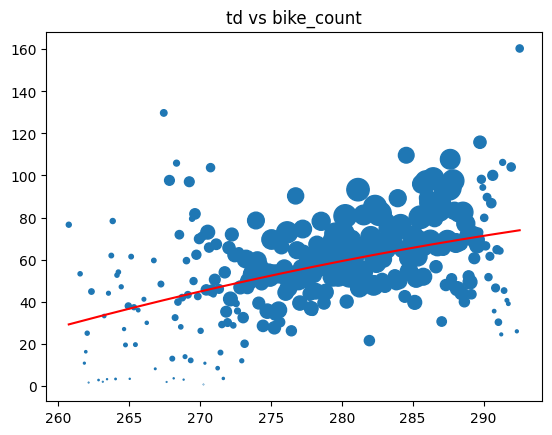

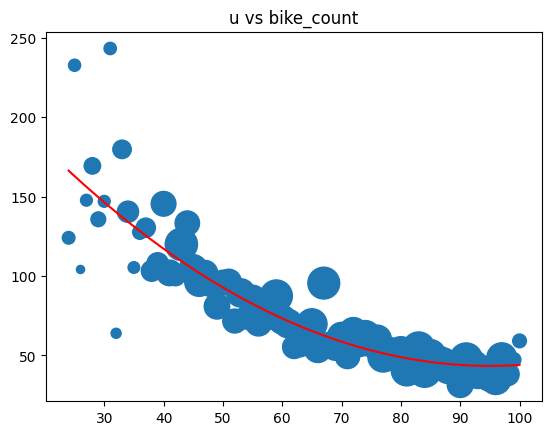

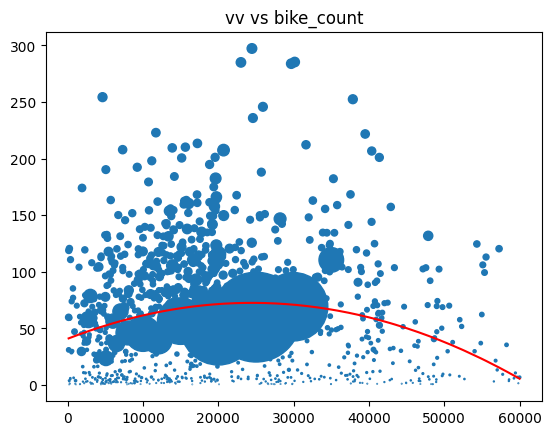

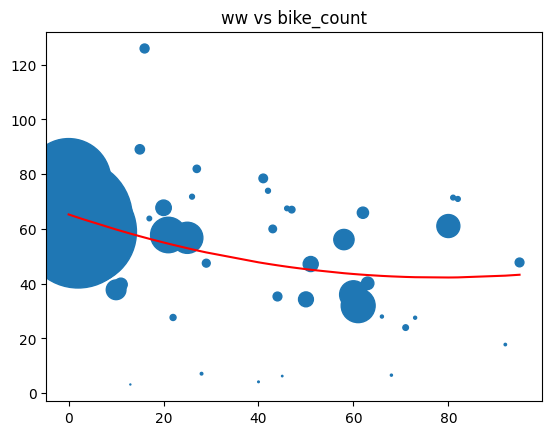

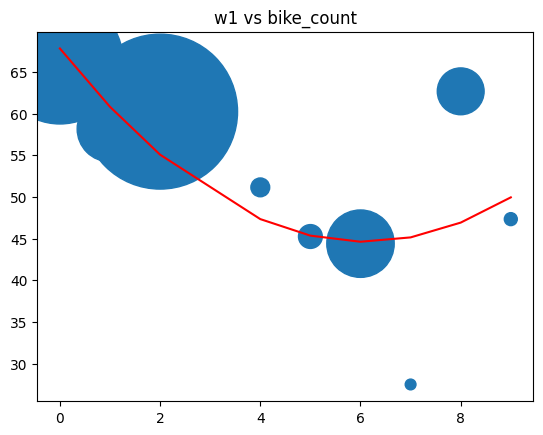

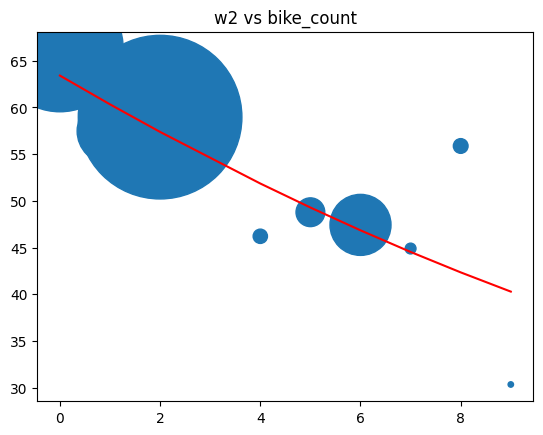

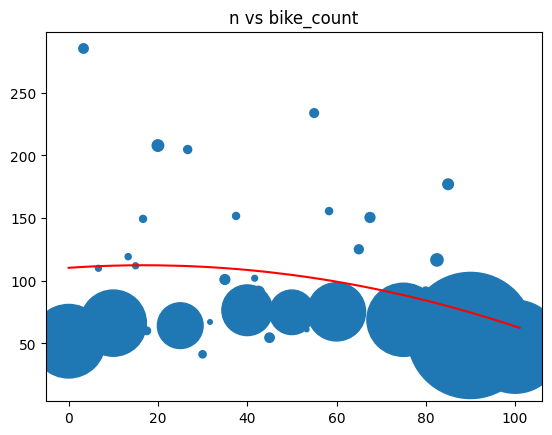

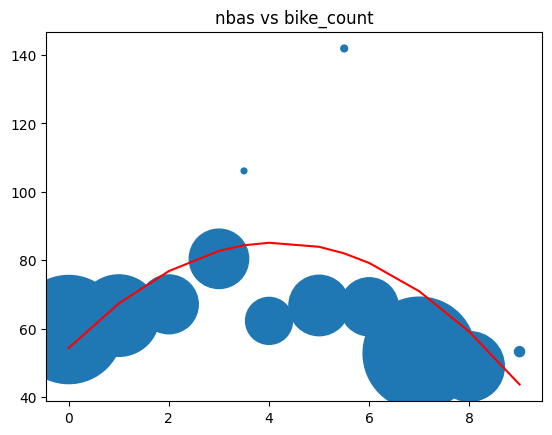

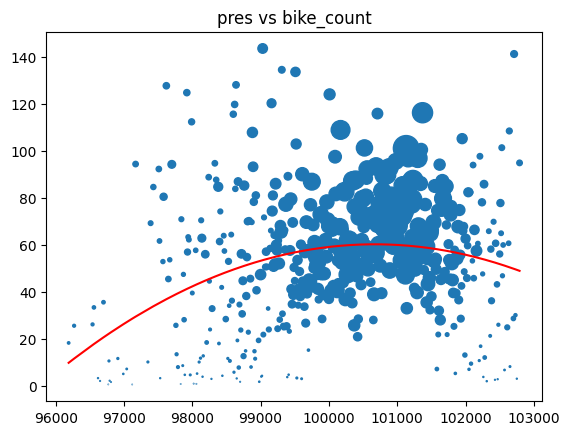

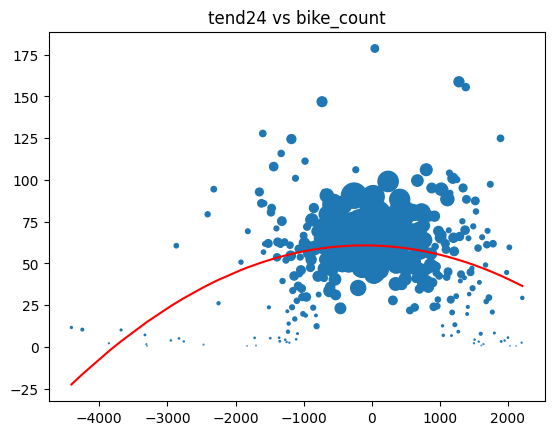

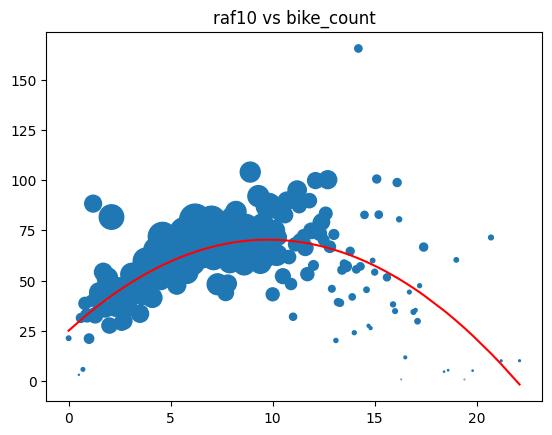

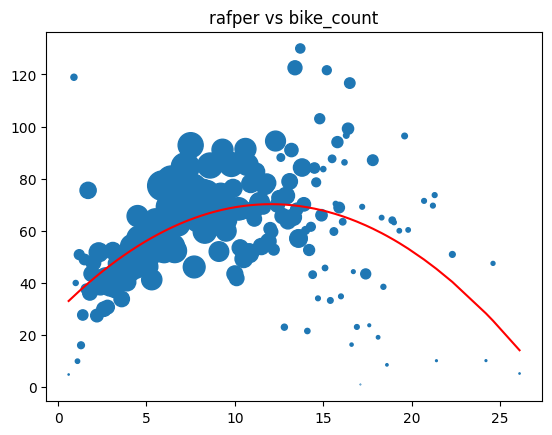

/usr/local/anaconda3/envs/bikes-ramp/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3433: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


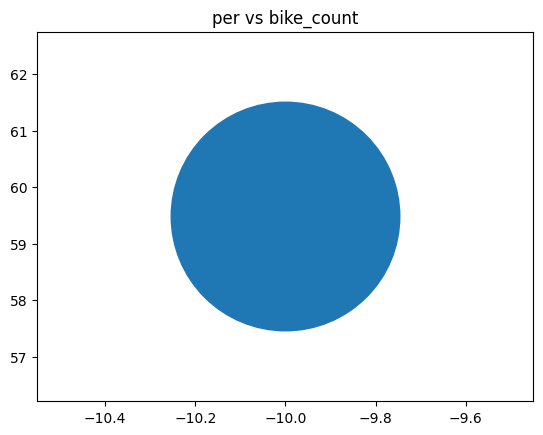

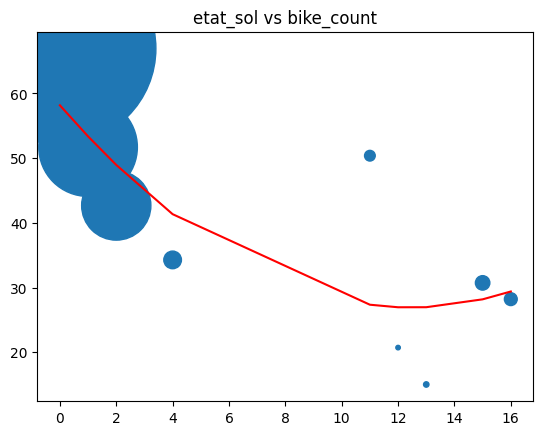

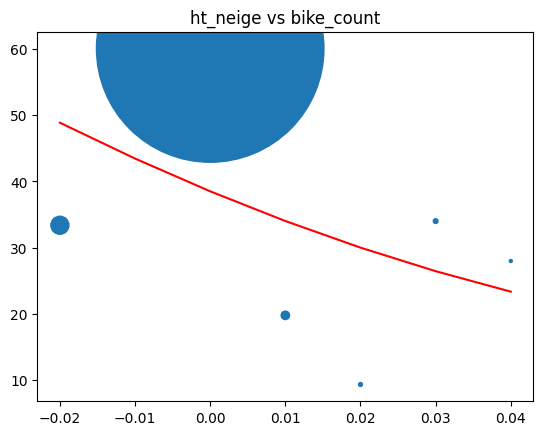

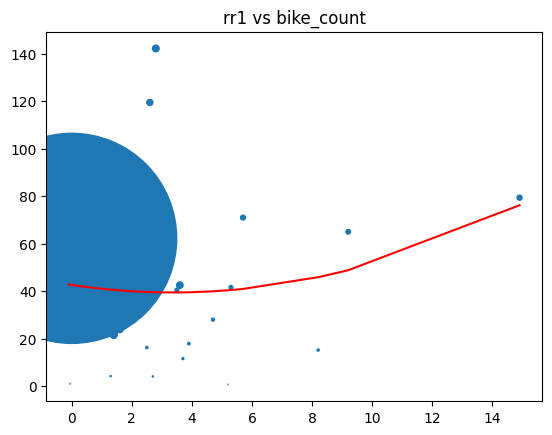

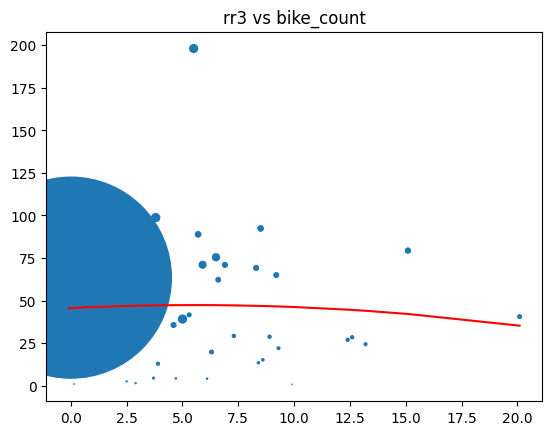

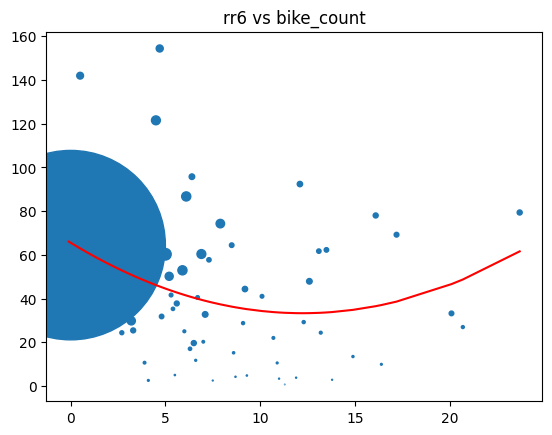

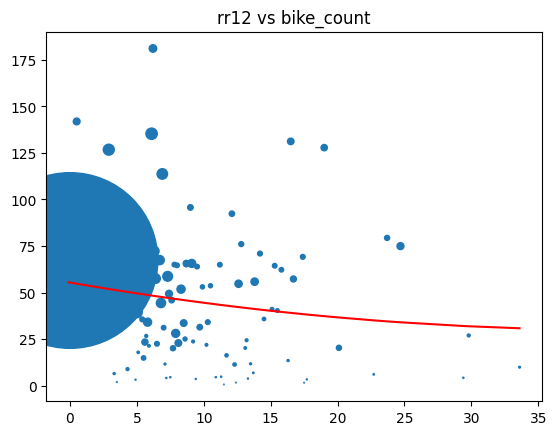

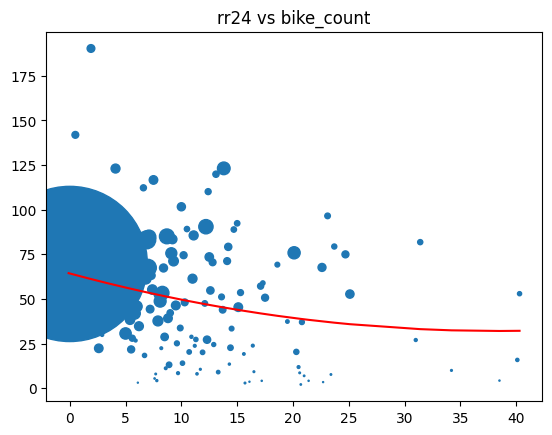

/usr/local/anaconda3/envs/bikes-ramp/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3433: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


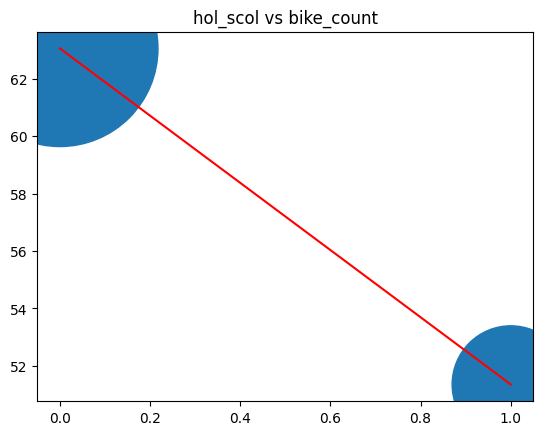

/usr/local/anaconda3/envs/bikes-ramp/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3433: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


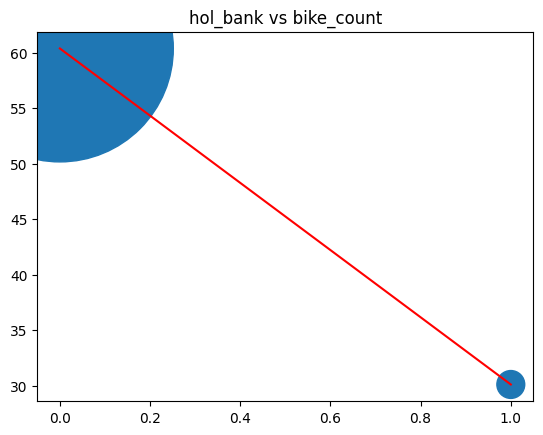

/usr/local/anaconda3/envs/bikes-ramp/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3433: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


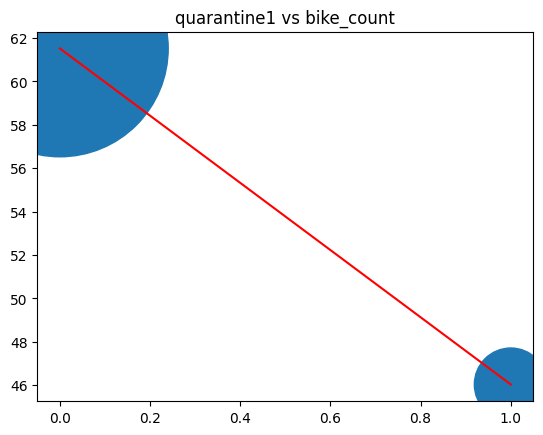

/usr/local/anaconda3/envs/bikes-ramp/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3433: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


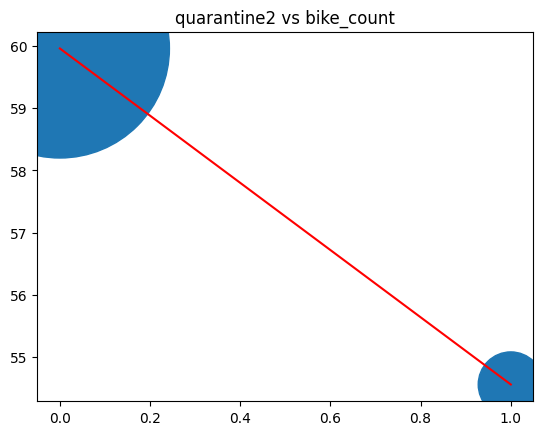

/usr/local/anaconda3/envs/bikes-ramp/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3433: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


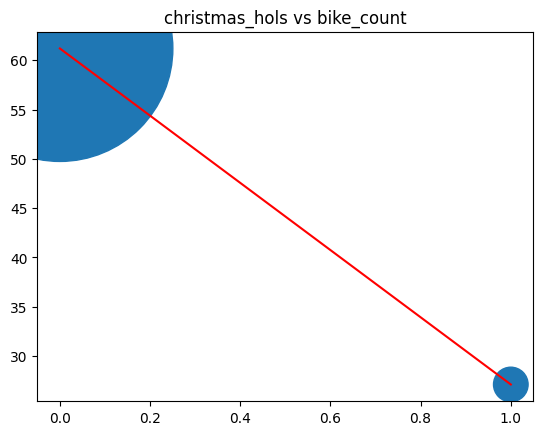

In [30]:
df_mask = df_merge_ext[df_merge_ext["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"]

for el in df_predictors.columns:
    plt.title(str(el) + " vs " + "bike_count")

    #df_plot = df_mask.groupby(pd.Grouper(key=el))[["bike_count"]].mean().sort_index()
    #df_plot1 = df_mask.groupby(pd.Grouper(key=el))[["bike_count"]].sum().sort_index()
    #Je pense que c'est ptt plus intéressant de regarder l'ensemble des counts non?
    
    df_plot = df_merge_ext.groupby(pd.Grouper(key=el))[["bike_count"]].mean().sort_index()
    df_plot1 = df_merge_ext.groupby(pd.Grouper(key=el))[["bike_count"]].sum().sort_index()

    plt.scatter(df_plot.index, df_plot["bike_count"], s=df_plot1["bike_count"]/1000)
    
    # coefficients for second order regression line 
    m1,m, b = np.polyfit(df_plot.index, df_plot["bike_count"],2)

    #use red as color for regression line
    plt.plot(df_plot.index, m1*df_plot.index**2 + m*df_plot.index+b, color='red')
    plt.show()
    

We observe that many predictors do not have linear relationship with the output variable and therefore, Ridge regression would be a poor choice of model if we were not transforming the predictors. Moreover, we see with these plots that the most interesting predictors are: `hol_bank` with a mean of 120 bike_count for True against 220 for False, `u`, `cod_tend`and `t`have strong linear relationship with `bike_count`and therefore should be included in the model. `quarantine1`is also much better than `quarantine2`to predict `bike_count`. The rest of the predictors should be tested, but with these plots we already have a baseline for which predictors should be included. <br>
The predictors we should not include are:  `rr3`,`rr1`,`per` because they do not dicriminate `bike_count`.

All counts :
Good: `cod_tend`, `ff`, `t`, `u`, `etat_sol`,`hol_scol`,`hol_bank`,`quarantine1`,`quarantine2`,`christmas_hols` <br>
Ok: `pmer`, `tend`,`td`, `ww`, `ww`,`w1`,`w1`,`w2`,`nbas`,`raf10`,`rafper`, `ht_neige` <br>
Bad:`dd`, `tend`,`dd`,`vv`,`n`,`pres`,`tend24`, `rr1` , `rr3` , `rr6` , `rr12`, `rr24` <br>

Changes when only first counter:
Good:  <br>
Ok:  <br>
Bad: `ww`, <br>

`pmer` = pressure <br>
`tend` = pressure variance in 3 hours <br>
`cod_tend` =  the difference between the atmospheric pressure at the time of observation and the atmospheric pressure three hours earlier <br>
`dd` = wind direction <br>
`ff` = wind speed <br>
`t` = temp <br>
`td` = dew point (affects rain) <br>
`u` = humidity <br>
`vv` = hor vis <br>
`ww` = present time (actually folowing the code it present weather) see https://www.jodc.go.jp/data_format/weather-code.html <br>
`w1` = Past weather http://www.weathergraphics.com/fcstbook/codes.pdf <br>
`w2` = Past weather http://www.weathergraphics.com/fcstbook/codes.pdf <br>
`n` = total cloudiness <br>
`nbas` = lower cloudiness <br>
`pres` = ?? presure <br>
`tend24` = pressure variations in 24hours <br>
`raf10` = gusts over the last 10min <br>
`rafper` = gusts over a period <br>
`per` = period of the burst <br> #only one value so not interesting
`etat_sol` =  https://artefacts.ceda.ac.uk/badc_datadocs/surface/code.html <br>
`ht_neige` = hight of snow <br>
`rr1` = prec in last hour <br>
`rr3` = prec in last 3 hours <br>
`rr6` = prec in last 6 hours <br>
`rr12` = prec in last 12 hours <br>
`rr24` = prec in last 24 hours <br>
`hol_scol` = <br>
`hol_bank` = <br>
`quarantine1` = <br>
`quarantine2` = <br>
`christmashol` = <br>

## 2) Model Selection

In [79]:
def _merge_external_data(X):
    columns_in_merged = ["date", "cod_tend", "ff", "t", "u", "etat_sol", "hol_scol", "hol_bank", "quarantine1", "quarantine2",
                         "christmas_hols", "pmer", "tend", "td", "ww", "w1", "w2", "nbas", "raf10", "rafper",
                         "ht_neige"]
    file_path = Path("data") / "external_data.csv"
    df_ext = pd.read_csv(file_path, parse_dates=["date"])
    
    linear_cols = ["n","nbas","tend24","raf10","ht_neige","rr1","rr3","rr6","rr12","rr24"]
    for col in linear_cols:
        df_ext[col] = df_ext[col].interpolate(method='linear',limit=4, limit_direction='both', axis=0)
    pad_cols = ["w1","w2","etat_sol"]
    for col in pad_cols:
        df_ext[col] = df_ext[col].interpolate(method='pad',limit=4, limit_direction='forward', axis=0)

    X = X.copy()
    # When using merge_asof left frame need to be sorted
    X["orig_index"] = np.arange(X.shape[0])

    X = pd.merge_asof(  # , "nbas" , "raf10"
        X.sort_values("date"), df_ext[columns_in_merged].sort_values("date").dropna(), on="date", direction="nearest")  #check result without direction=nearest 
    # Sort back to the original order
    X = X.sort_values("orig_index")
    del X["orig_index"]
    return X


def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    X.loc[:, "weekend"] = X["weekday"] > 4

    X['sin_hours'] = np.sin(2*np.pi*X["hour"]/24)
    X['cos_hours'] = np.cos(2*np.pi*X["hour"]/24)

    X['sin_mnth'] = np.sin(2*np.pi*X["month"]/12)
    X['cos_mnth'] = np.cos(2*np.pi*X["month"]/12)

    return X.drop(columns=["date"])


First we create a function to easily get the different features we want to test.
We get:
- the features that do not need to be preprocessed 
- the categorical features that need 1-0 encoding

In [53]:
# function to get the features that do not need to be processed
def get_passthrough(date = "transformed_date", list_of_temp=[]):
    """function to get the features that will not be transformed at the prepocessing stage

    Args:
        date (str): "both_date": select all the date features                   
                    "original_date": selecte date without sin transformed
                    "transformed_date": select date with sin-cos transformation

        list_of_temp (list): list of features (no date) that will not be transformed

    Returns:
        _type_: features to not be transformed  
    """
    pass_through_cols = []
    
    if "original_date" == date:
        pass_through_cols = ["year","month","day","weekday","hour"]

    if "both_date" == date:
        pass_through_cols = ["year","month","day","weekday","hour",
                             "sin_hours", "cos_hours", "sin_mnth", "cos_mnth"]

    if "transformed_date" == date:
        pass_through_cols = ["year", "day", "weekday",
                             "sin_mnth", "cos_mnth","sin_hours", "cos_hours"]
        
    if "transformed_date_no_year" == date:
        pass_through_cols = ["day", "weekday",
                             "sin_mnth", "cos_mnth","sin_hours", "cos_hours"]
        
    if "transformed_date_no_day" == date:
        pass_through_cols = [ "year", "weekday",
                             "sin_mnth", "cos_mnth","sin_hours", "cos_hours"]
    if "transformed_date_no_year_no_day" == date:
        pass_through_cols = ["weekday",
                             "sin_mnth", "cos_mnth","sin_hours", "cos_hours"]
    for el in list_of_temp:
        pass_through_cols.append(el)

    return pass_through_cols


In [43]:
def get_estimator(pass_through_cols, categorical_cols, regressor=XGBRegressor()):

    # define the encoders
    categorical_encoder = OneHotEncoder(handle_unknown="ignore")
    date_encoder = FunctionTransformer(_encode_dates)

    # define the transformation of data before using regressor
    if pass_through_cols != []:
        preprocessor = ColumnTransformer(
            [
                ("cat", categorical_encoder, categorical_cols),
                ("std_scaler", StandardScaler(), pass_through_cols),
                #("passthrough", "passthrough", pass_through_cols)
            ],
        )
    
    else:
        preprocessor = ColumnTransformer(
            [
                ("cat", categorical_encoder, categorical_cols),
                ("std_scaler", StandardScaler(), pass_through_cols),
                #("passthrough", "passthrough", pass_through_cols)
            ],
        )
    pipe = make_pipeline(
        FunctionTransformer(_merge_external_data, validate=False),
        date_encoder,
        preprocessor,
        regressor,
    )

    return pipe


In [35]:
# test
#a = ["sin_hours", "cos_hours", "sin_mnth", "cos_mnth"]
#b = ["counter_name", "site_name", "weekday", "weekend"]
#model = get_estimator([], b, )
#model


In [36]:
import problem
#X_train, y_train = problem.get_train_data()
#X_test, y_test = problem.get_test_data()
#model.fit(X_train, y_train)

In [37]:
#from sklearn.metrics import mean_squared_error
#print(f"Train set, RMSE={mean_squared_error(y_train, model.predict(X_train), squared=False):.2f}")
#print(f"Test set, RMSE={mean_squared_error(y_test, model.predict(X_test), squared=False):.2f}")

In [38]:
def test_model(pass_throughs_col, categorical_cols, regressor = XGBRegressor(max_depth = 4, subsample = 0.8)):
    """test a model given the features and the regressor and output the prediction on the test data set and the scores on train and test

    Args:
        pass_throughs_col (list): list of features not to be transform during pre-processing step
        categorical_cols (list): columns to be one hot encoded
        regressor (regressor to use in our model, optional): scikit compatible function. Defaults to XGBRegressor().

    Returns:
        array,float,float: the prediction on the test set, the score on the training set, the score on the testing set
    """
    X_train, y_train = problem.get_train_data()
    X_test, y_test = problem.get_test_data()    
    model = get_estimator(pass_throughs_col,categorical_cols,regressor)
    model.fit(X_train, y_train)
    
    cv = TimeSeriesSplit(n_splits=6)

    scores = cross_val_score(
        model, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
    )
    #print("RMSE: ", scores)
    #print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

    #return model.predict(X_test), mean_squared_error(y_train, model.predict(X_train)), mean_squared_error(y_test, model.predict(X_test), squared=False)
    return model.predict(X_test), round(mean_squared_error(y_train, model.predict(X_train)),3), \
        round(-scores.mean(),3), round(-scores.std(),3) , \
        round(mean_squared_error(y_test, model.predict(X_test), squared=False),3)

    

Now that we have our functions to test different models quickly, we are going to try some different models using linear regression and Xgboost and compare the RMSE. Because XGboost tends to overfitt, we are going to limit the complexity of our model to an arbitrary threshold.<br>
We are going to test:
- the minimum model with date not transformed and no external data added
- min model with date transformed (we dont use both dates as it is redundant)
- min model with weather 
- min model with quarantine 
- min model with holidays

Then we are going to try different combination of the above models.

In [39]:
# first test the min models for different regressors
from sklearn.neural_network import MLPRegressor
estimator = [RidgeCV(), XGBRegressor(max_depth = 4, subsample = 0.8), MLPRegressor(hidden_layer_sizes=(16,8), max_iter=300),
            MLPRegressor(hidden_layer_sizes=(16,8),alpha = 0.001, max_iter=300)]
date_no_transformed = get_passthrough("original_date")
category_base = ["counter_name", "site_name"]
# min model 
for regressors in estimator:
    _,score_train,cv_score,std,score_test = test_model([],date_no_transformed + category_base, regressors)

    print(f"For model with {regressors}:")
    print(f"the categorical predictors are: {date_no_transformed + category_base}")
    print(f"the score on training is {score_train}")
    print(f"the cv_score is {cv_score}")
    print(f"the std is {std}")
    print(f"the score on testing is {score_test}")



For model with RidgeCV():
the categorical predictors are: ['year', 'month', 'day', 'weekday', 'hour', 'counter_name', 'site_name']
the score on training is 0.641
the score on testing is 0.725
the std is -0.074
For model with XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...):
the categorical predictors are: ['year', 'month', 'day', 'weekday', 'h

In [42]:
estimator = [MLPRegressor(hidden_layer_sizes=(8,4),alpha = 0.001, max_iter=200)]
date_no_transformed = get_passthrough("original_date")
category_base = ["counter_name", "site_name"]
# min model 
for regressors in estimator:
    _,score_train,cv_score,std,score_test = test_model([],date_no_transformed + category_base, regressors)
    print(f"For model with {regressors}:")
    print(f"the categorical predictors are: {date_no_transformed + category_base}")
    print(f"the score on training is {score_train}")
    print(f"the cv_score is {cv_score}")
    print(f"the std is {std}")
    print(f"the score on testing is {score_test}")

For model with MLPRegressor(alpha=0.001, hidden_layer_sizes=(8, 4)):
the categorical predictors are: ['year', 'month', 'day', 'weekday', 'hour', 'counter_name', 'site_name']
the score on training is 0.24
the score on testing is 0.573
the std is -0.256


In [44]:
estimator = [MLPRegressor(hidden_layer_sizes=(8,4),alpha = 0.001, max_iter=200)]
date_no_transformed = get_passthrough("original_date")
category_base = ["counter_name", "site_name"]
# min model 
for regressors in estimator:
    _,score_train,cv_score,std,score_test = test_model([],date_no_transformed + category_base, regressors)
    print(f"For model with {regressors}:")
    print(f"the categorical predictors are: {date_no_transformed + category_base}")
    print(f"the score on training is {score_train}")
    print(f"the cv_score is {cv_score}")
    print(f"the std is {std}")
    print(f"the score on testing is {score_test}")

For model with MLPRegressor(alpha=0.001, hidden_layer_sizes=(8, 4)):
the categorical predictors are: ['year', 'month', 'day', 'weekday', 'hour', 'counter_name', 'site_name']
the score on training is 0.262
the score on testing is 0.546
the std is -0.19


In [51]:
estimator = [MLPRegressor(hidden_layer_sizes=(8,4),alpha = 0.001, max_iter=300)]
date_no_transformed = get_passthrough("original_date")
category_base = ["counter_name", "site_name"]
# min model 
for regressors in estimator:
    _,score_train,cv_score,std,score_test = test_model([],date_no_transformed + category_base, regressors)
    print(f"For model with {regressors}:")
    print(f"the categorical predictors are: {date_no_transformed + category_base}")
    print(f"the score on training is {score_train}")
    print(f"the cv_score is {cv_score}")
    print(f"the std is {std}")
    print(f"the score on testing is {score_test}")

For model with MLPRegressor(alpha=0.001, hidden_layer_sizes=(8, 4), max_iter=300):
the categorical predictors are: ['year', 'month', 'day', 'weekday', 'hour', 'counter_name', 'site_name']
the score on training is 0.239
the score on testing is 0.531
the std is -0.188


As can be seen a simple model of XGBoost overperforms the RidgeCV model. Will continue with XGBoost.

Test for the dates : <br> 
"both_date": select all the date features  <br>                 
"original_date": selecte date without sin transformed <br>     
"transformed_date": select date with sin-cos transformation <br>   
"transformed_date_no_year": select date with sin-cos transformation no year <br> 
"transformed_date_no_day": select date with sin-cos transformation no year <br> 
"transformed_date_no_year_no_day": select date with sin-cos transformation no year <br> 


In [54]:
different_dates_options = ["both_date", "original_date","transformed_date","transformed_date_no_year",
                          "transformed_date_no_day","transformed_date_no_year_no_day"]
categorical_cols = ["counter_name", "site_name", "weekday"]
for date_options in different_dates_options:
    pass_through_cols = []
    passthrough = get_passthrough(date_options, pass_through_cols)
    _,score_train,cv_score,std,score_test = test_model(passthrough, categorical_cols,
                                                regressor = XGBRegressor(max_depth=5, n_estimators=150, subsample = 0.8))
    print(f"For model with dates {date_options}:")
    print(f"the passthrough predictors are: {passthrough}")
    print(f"the categorical predictors are: {categorical_cols}")
    print(f"the score on training is {score_train}")
    print(f"the cv_score is {cv_score}")
    print(f"the std is {std}")
    print(f"the score on testing is {score_test}")

For model with dates both_date:
the passthrough predictors are: ['year', 'month', 'day', 'weekday', 'hour', 'sin_hours', 'cos_hours', 'sin_mnth', 'cos_mnth']
the categorical predictors are: ['counter_name', 'site_name', 'weekday']
the score on training is 0.191
the score on testing is 0.477
the std is -0.145
For model with dates original_date:
the passthrough predictors are: ['year', 'month', 'day', 'weekday', 'hour']
the categorical predictors are: ['counter_name', 'site_name', 'weekday']
the score on training is 0.194
the score on testing is 0.551
the std is -0.137
For model with dates transformed_date:
the passthrough predictors are: ['year', 'day', 'weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours']
the categorical predictors are: ['counter_name', 'site_name', 'weekday']
the score on training is 0.194
the score on testing is 0.502
the std is -0.055
For model with dates transformed_date_no_year:
the passthrough predictors are: ['day', 'weekday', 'sin_mnth', 'cos_mnth', 'sin

transformed_date_no_year_no_day is the best one

Test for extra categorical : <br>
#"weekend","hol_scol","hol_bank","quarantine1", "quarantine2","christmas_hols"

In [62]:
date_options = "transformed_date_no_year_no_day"
extra_cat_cols = ["counter_name", "site_name"]
for extra_cat_col in extra_cat_cols:
    categorical_cols_temp = []
    categorical_cols_temp.append(extra_cat_col)
    pass_through_cols = []
    passthrough = get_passthrough(date_options, pass_through_cols)
    _,score_train,cv_score,std,score_test = test_model(passthrough, categorical_cols_temp,
                                                regressor = XGBRegressor(max_depth=5, n_estimators=150, subsample = 0.8))
    print(f"For model with dates {date_options}:")
    print(f"the passthrough predictors are: {passthrough}")
    print(f"the categorical predictors are: {categorical_cols_temp}")
    print(f"the score on training is {score_train}")
    print(f"the cv_score is {cv_score}")
    print(f"the std is {std}")
    print(f"the score on testing is {score_test}")

For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours']
the categorical predictors are: ['counter_name']
the score on training is 0.274
the score on testing is 0.446
the std is -0.049
For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours']
the categorical predictors are: ['site_name']
the score on training is 0.379
the score on testing is 0.55
the std is -0.054


In [60]:
date_options = "transformed_date_no_year_no_day"
cat_cols = ["counter_name"]
extra_cat_cols = ["site_name"]
for extra_cat_col in extra_cat_cols:
    categorical_cols_temp = cat_cols.copy()
    categorical_cols_temp.append(extra_cat_col)
    pass_through_cols = []
    passthrough = get_passthrough(date_options, pass_through_cols)
    _,score_train,cv_score,std,score_test = test_model(passthrough, categorical_cols_temp,
                                                regressor = XGBRegressor(max_depth=5, n_estimators=150, subsample = 0.8))
    print(f"For model with dates {date_options}:")
    print(f"the passthrough predictors are: {passthrough}")
    print(f"the categorical predictors are: {categorical_cols_temp}")
    print(f"the score on training is {score_train}")
    print(f"the cv_score is {cv_score}")
    print(f"the std is {std}")
    print(f"the score on testing is {score_test}")

For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours']
the categorical predictors are: ['counter_name', 'site_name']
the score on training is 0.266
the score on testing is 0.441
the std is -0.055


['counter_name', 'site_name'] need to be included

In [61]:
date_options = "transformed_date_no_year_no_day"
cat_cols = ["counter_name","site_name"]
extra_cat_cols =  ["weekend","hol_scol","hol_bank","quarantine1", "quarantine2","christmas_hols"]
for extra_cat_col in extra_cat_cols:
    categorical_cols_temp = cat_cols.copy()
    categorical_cols_temp.append(extra_cat_col)
    pass_through_cols = []
    passthrough = get_passthrough(date_options, pass_through_cols)
    _,score_train,cv_score,std,score_test = test_model(passthrough, categorical_cols_temp,
                                                regressor = XGBRegressor(max_depth=5, n_estimators=150, subsample = 0.8))
    print(f"For model with dates {date_options}:")
    print(f"the passthrough predictors are: {passthrough}")
    print(f"the categorical predictors are: {categorical_cols_temp}")
    print(f"the score on training is {score_train}")
    print(f"the cv_score is {cv_score}")
    print(f"the std is {std}")
    print(f"the score on testing is {score_test}")

For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours']
the categorical predictors are: ['counter_name', 'site_name', 'weekend']
the score on training is 0.266
the score on testing is 0.441
the std is -0.055
For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours']
the categorical predictors are: ['counter_name', 'site_name', 'hol_scol']
the score on training is 0.238
the score on testing is 0.442
the std is -0.084
For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours']
the categorical predictors are: ['counter_name', 'site_name', 'hol_bank']
the score on training is 0.252
the score on testing is 0.45
the std is -0.061
For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', '

In [63]:
#thosse one are optimal
cat_cols_1 = ["counter_name","site_name", "quarantine2"]
#don't really affect the model but should be kept when I use MLP or deeper XGB
cat_cols_2 = ["counter_name","site_name","weekend","hol_scol", "quarantine2","christmas_hols"]
#affect the model negatively but should be kept when I use MLP or deeper XGB
cat_cols_3 = ["counter_name","site_name","weekend","hol_scol","hol_bank","quarantine1", "quarantine2","christmas_hols"]

Test for the extra weather:
Good: `cod_tend`, `ff`, `t`, `u`, `etat_sol` <br>

In [65]:
date_options = "transformed_date_no_year_no_day"
categorical_cols = cat_cols_1
pass_through_meteo_good = ["cod_tend", "ff","t", "u", "etat_sol"]
for pass_through_meteo in pass_through_meteo_good:
    pass_through_cols = [pass_through_meteo]
    passthrough = get_passthrough(date_options, pass_through_cols)
    _,score_train,cv_score,std,score_test = test_model(passthrough, categorical_cols,
                                                regressor = XGBRegressor(max_depth=5, n_estimators=150, subsample = 0.8))
    print(f"For model with dates {date_options}:")
    print(f"the passthrough predictors are: {passthrough}")
    print(f"the categorical predictors are: {categorical_cols_temp}")
    print(f"the score on training is {score_train}")
    print(f"the cv_score is {cv_score}")
    print(f"the std is {std}")
    print(f"the score on testing is {score_test}")

For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours', 'cod_tend']
the categorical predictors are: ['site_name']
the score on training is 0.255
the cv_scores are 0.738
the std is -0.049
the score on testing is 0.443
For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours', 'ff']
the categorical predictors are: ['site_name']
the score on training is 0.245
the cv_scores are 0.74
the std is -0.045
the score on testing is 0.462
For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours', 't']
the categorical predictors are: ['site_name']
the score on training is 0.23
the cv_scores are 0.757
the std is -0.063
the score on testing is 0.458
For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['

Without interpol:
For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours', 'cod_tend']
the categorical predictors are: ['site_name']
the score on training is 0.255
the cv_scores are 0.738
the std is -0.049
the score on testing is 0.443
For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours', 'ff']
the categorical predictors are: ['site_name']
the score on training is 0.245
the cv_scores are 0.74
the std is -0.045
the score on testing is 0.462
For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours', 't']
the categorical predictors are: ['site_name']
the score on training is 0.23
the cv_scores are 0.757
the std is -0.063
the score on testing is 0.458
For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours', 'u']
the categorical predictors are: ['site_name']
the score on training is 0.242
the cv_scores are 0.739
the std is -0.06
the score on testing is 0.44
For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours', 'etat_sol']
the categorical predictors are: ['site_name']
the score on training is 0.243
the cv_scores are 0.724
the std is -0.061
the score on testing is 0.434

With interpol:

In [67]:
date_options = "transformed_date_no_year_no_day"
categorical_cols = cat_cols_1
pass_through_meteo_good = ["cod_tend", "ff","t", "u", "etat_sol"]
for pass_through_meteo in pass_through_meteo_good:
    pass_through_cols = [pass_through_meteo]
    passthrough = get_passthrough(date_options, pass_through_cols)
    _,score_train,cv_score,std,score_test = test_model(passthrough, categorical_cols,
                                                regressor = XGBRegressor(max_depth=5, n_estimators=150, subsample = 0.8))
    print(f"For model with dates {date_options}:")
    print(f"the passthrough predictors are: {passthrough}")
    print(f"the categorical predictors are: {categorical_cols_temp}")
    print(f"the score on training is {score_train}")
    print(f"the cv_score is {cv_score}")
    print(f"the std is {std}")
    print(f"the score on testing is {score_test}")

For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours', 'cod_tend']
the categorical predictors are: ['site_name']
the score on training is 0.254
the cv_score is 0.74
the std is -0.05
the score on testing is 0.444
For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours', 'ff']
the categorical predictors are: ['site_name']
the score on training is 0.243
the cv_score is 0.747
the std is -0.043
the score on testing is 0.458
For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours', 't']
the categorical predictors are: ['site_name']
the score on training is 0.231
the cv_score is 0.751
the std is -0.075
the score on testing is 0.448
For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekda

The results are improved on a general note with the interpolation

In [68]:
#those ones improved the score
pass_through_meteo_good_1 = ["etat_sol"]
#don't really affect the model but should be kept when I use MLP or deeper XGB
pass_through_meteo_good_2 = ["cod_tend", "ff","t", "u", "etat_sol"]

Test for the extra weather:
Ok: `pmer`, `tend`,`td`, `ww`,`w1`,`w2`,`nbas`,`raf10`,`rafper`, `ht_neige` <br>

In [72]:
date_options = "transformed_date_no_year_no_day"
categorical_cols = cat_cols_1
pass_through_meteo_good = ["etat_sol"]
#pass_through_meteo_ok = ["pmer", "tend","td", "ww", "w1", "w2", "nbas", "raf10", "rafper", "ht_neige"]
pass_through_meteo_ok = ["nbas", "raf10", "rafper", "ht_neige"] #"ww", "w1", "w2"
for pass_through_meteo in pass_through_meteo_ok:
    pass_through_cols = pass_through_meteo_good.copy()
    pass_through_cols.append(pass_through_meteo)
    passthrough = get_passthrough(date_options, pass_through_cols)
    _,score_train,cv_score,std,score_test = test_model(passthrough, categorical_cols,
                                                regressor = XGBRegressor(max_depth=5, n_estimators=150, subsample = 0.8))
    print(f"For model with dates {date_options}:")
    print(f"the passthrough predictors are: {passthrough}")
    print(f"the categorical predictors are: {categorical_cols_temp}")
    print(f"the score on training is {score_train}")
    print(f"the cv_score is {cv_score}")
    print(f"the std is {std}")
    print(f"the score on testing is {score_test}")

For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours', 'etat_sol', 'nbas']
the categorical predictors are: ['site_name']
the score on training is 0.238
the cv_score is 0.732
the std is -0.054
the score on testing is 0.44
For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours', 'etat_sol', 'raf10']
the categorical predictors are: ['site_name']
the score on training is 0.231
the cv_score is 0.735
the std is -0.05
the score on testing is 0.451
For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours', 'etat_sol', 'rafper']
the categorical predictors are: ['site_name']
the score on training is 0.23
the cv_score is 0.735
the std is -0.054
the score on testing is 0.447
For model with dates transformed_date_no_year_no_day:
t

In [80]:
date_options = "transformed_date_no_year_no_day"
categorical_cols = cat_cols_1
pass_through_meteo_good = ["etat_sol"]
pass_through_meteo_ok = ["ww", "w1", "w2"]
for pass_through_meteo in pass_through_meteo_ok:
    pass_through_cols = pass_through_meteo_good.copy()
    pass_through_cols.append(pass_through_meteo)
    passthrough = get_passthrough(date_options, pass_through_cols)
    _,score_train,cv_score,std,score_test = test_model(passthrough, categorical_cols,
                                                regressor = XGBRegressor(max_depth=5, n_estimators=150, subsample = 0.8))
    print(f"For model with dates {date_options}:")
    print(f"the passthrough predictors are: {passthrough}")
    print(f"the categorical predictors are: {categorical_cols_temp}")
    print(f"the score on training is {score_train}")
    print(f"the cv_score is {cv_score}")
    print(f"the std is {std}")
    print(f"the score on testing is {score_test}")

For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours', 'etat_sol', 'ww']
the categorical predictors are: ['site_name']
the score on training is 0.237
the cv_score is 0.721
the std is -0.064
the score on testing is 0.434
For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours', 'etat_sol', 'w1']
the categorical predictors are: ['site_name']
the score on training is 0.234
the cv_score is 0.729
the std is -0.057
the score on testing is 0.435
For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours', 'etat_sol', 'w2']
the categorical predictors are: ['site_name']
the score on training is 0.235
the cv_score is 0.733
the std is -0.055
the score on testing is 0.431


In [83]:
#don't really affect the model but should be kept when I use MLP or deeper XGB
pass_through_meteo_ok_2 = ["nbas", "ht_neige","ww","w1","w2"]

We now test the obtained features with a deeper model

In [82]:
date_options = "transformed_date_no_year_no_day"
categorical_cols = [cat_cols_1,cat_cols_2,cat_cols_3]
for categorical_col in categorical_cols:
    pass_through_cols = []
    passthrough = get_passthrough(date_options, pass_through_cols)
    _,score_train,cv_score,std,score_test = test_model(passthrough, categorical_col,
                                                regressor =XGBRegressor(max_depth = 9, n_estimators=250, subsample = 0.8))
    print(f"For model with dates {date_options}:")
    print(f"the passthrough predictors are: {passthrough}")
    print(f"the categorical predictors are: {categorical_col}")
    print(f"the score on training is {score_train}")
    print(f"the cv_score is {cv_score}")
    print(f"the std is {std}")
    print(f"the score on testing is {score_test}")

For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours']
the categorical predictors are: ['counter_name', 'site_name', 'quarantine2']
the score on training is 0.215
the cv_score is 0.752
the std is -0.054
the score on testing is 0.427
For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours']
the categorical predictors are: ['counter_name', 'site_name', 'weekend', 'hol_scol', 'quarantine2', 'christmas_hols']
the score on training is 0.165
the cv_score is 0.791
the std is -0.08
the score on testing is 0.426
For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours']
the categorical predictors are: ['counter_name', 'site_name', 'weekend', 'hol_scol', 'hol_bank', 'quarantine1', 'quarantine2', 'christmas_hols']
the score on tr

In [84]:
date_options = "transformed_date_no_year_no_day"
categorical_cols = cat_cols_2
pass_through_meteo_goods = [pass_through_meteo_good_1,pass_through_meteo_good_2]
for pass_through_meteo_goods in pass_through_meteo_goods:
    passthrough = get_passthrough(date_options, pass_through_meteo_goods)
    _,score_train,cv_score,std,score_test = test_model(passthrough, categorical_cols,
                                                regressor =XGBRegressor(max_depth = 9, n_estimators=250, subsample = 0.8))
    print(f"For model with dates {date_options}:")
    print(f"the passthrough predictors are: {passthrough}")
    print(f"the categorical predictors are: {categorical_cols}")
    print(f"the score on training is {score_train}")
    print(f"the cv_score is {cv_score}")
    print(f"the std is {std}")
    print(f"the score on testing is {score_test}")

For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours', 'etat_sol']
the categorical predictors are: ['counter_name', 'site_name', 'weekend', 'hol_scol', 'quarantine2', 'christmas_hols']
the score on training is 0.129
the cv_score is 0.794
the std is -0.071
the score on testing is 0.414
For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours', 'cod_tend', 'ff', 't', 'u', 'etat_sol']
the categorical predictors are: ['counter_name', 'site_name', 'weekend', 'hol_scol', 'quarantine2', 'christmas_hols']
the score on training is 0.078
the cv_score is 0.756
the std is -0.071
the score on testing is 0.455


In [86]:
date_options = "transformed_date_no_year_no_day"
categorical_cols = cat_cols_2
pass_through_meteo_goods = pass_through_meteo_good_1 + pass_through_meteo_ok_2
passthrough = get_passthrough(date_options, pass_through_meteo_goods)
_,score_train,cv_score,std,score_test = test_model(passthrough, categorical_cols,
                                            regressor =XGBRegressor(max_depth = 9, n_estimators=250, subsample = 0.8))
print(f"For model with dates {date_options}:")
print(f"the passthrough predictors are: {passthrough}")
print(f"the categorical predictors are: {categorical_cols}")
print(f"the score on training is {score_train}")
print(f"the cv_score is {cv_score}")
print(f"the std is {std}")
print(f"the score on testing is {score_test}")

For model with dates transformed_date_no_year_no_day:
the passthrough predictors are: ['weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours', 'etat_sol', 'nbas', 'ht_neige', 'ww', 'w1', 'w2']
the categorical predictors are: ['counter_name', 'site_name', 'weekend', 'hol_scol', 'quarantine2', 'christmas_hols']
the score on training is 0.087
the cv_score is 0.78
the std is -0.084
the score on testing is 0.43


In [87]:
date_options = "transformed_date"
categorical_cols = cat_cols_2
pass_through_meteo_goods = pass_through_meteo_good_1
passthrough = get_passthrough(date_options, pass_through_meteo_goods)
_,score_train,cv_score,std,score_test = test_model(passthrough, categorical_cols,
                                            regressor =XGBRegressor(max_depth = 9, n_estimators=250, subsample = 0.8))
print(f"For model with dates {date_options}:")
print(f"the passthrough predictors are: {passthrough}")
print(f"the categorical predictors are: {categorical_cols}")
print(f"the score on training is {score_train}")
print(f"the cv_score is {cv_score}")
print(f"the std is {std}")
print(f"the score on testing is {score_test}")

For model with dates transformed_date:
the passthrough predictors are: ['year', 'day', 'weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours', 'etat_sol']
the categorical predictors are: ['counter_name', 'site_name', 'weekend', 'hol_scol', 'quarantine2', 'christmas_hols']
the score on training is 0.076
the cv_score is 0.791
the std is -0.055
the score on testing is 0.424


In [88]:
#The best features for XGBoost are thus:
date_options = "transformed_date"
categorical_cols = cat_cols_2
pass_through_meteo_goods = pass_through_meteo_good_1
passthrough = get_passthrough(date_options, pass_through_meteo_goods)

We now test the obtained features with a MLP

In [89]:
date_options = "transformed_date"
categorical_cols = [cat_cols_1,cat_cols_2,cat_cols_3]
for categorical_col in categorical_cols:
    pass_through_cols = []
    passthrough = get_passthrough(date_options, pass_through_cols)
    _,score_train,cv_score,std,score_test = test_model(passthrough, categorical_col,
                                                regressor =MLPRegressor(hidden_layer_sizes=(8,4),alpha = 0.001, max_iter=300))
    print(f"For model with dates {date_options}:")
    print(f"the passthrough predictors are: {passthrough}")
    print(f"the categorical predictors are: {categorical_col}")
    print(f"the score on training is {score_train}")
    print(f"the cv_score is {cv_score}")
    print(f"the std is {std}")
    print(f"the score on testing is {score_test}")

For model with dates transformed_date:
the passthrough predictors are: ['year', 'day', 'weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours']
the categorical predictors are: ['counter_name', 'site_name', 'quarantine2']
the score on training is 0.331
the cv_score is 2.81
the std is -3.358
the score on testing is 0.631
For model with dates transformed_date:
the passthrough predictors are: ['year', 'day', 'weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours']
the categorical predictors are: ['counter_name', 'site_name', 'weekend', 'hol_scol', 'quarantine2', 'christmas_hols']
the score on training is 0.316
the cv_score is 1.106
the std is -0.253
the score on testing is 0.74
For model with dates transformed_date:
the passthrough predictors are: ['year', 'day', 'weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours']
the categorical predictors are: ['counter_name', 'site_name', 'weekend', 'hol_scol', 'hol_bank', 'quarantine1', 'quarantine2', 'christmas_hols']
the score on tra

In [90]:
date_options = "transformed_date"
categorical_cols = cat_cols_2
pass_through_meteo_goods = [pass_through_meteo_good_1,pass_through_meteo_good_2]
for pass_through_meteo_goods in pass_through_meteo_goods:
    passthrough = get_passthrough(date_options, pass_through_meteo_goods)
    _,score_train,cv_score,std,score_test = test_model(passthrough, categorical_cols,
                                                regressor =MLPRegressor(hidden_layer_sizes=(8,4),alpha = 0.001, max_iter=300))
    print(f"For model with dates {date_options}:")
    print(f"the passthrough predictors are: {passthrough}")
    print(f"the categorical predictors are: {categorical_cols}")
    print(f"the score on training is {score_train}")
    print(f"the cv_score is {cv_score}")
    print(f"the std is {std}")
    print(f"the score on testing is {score_test}")

For model with dates transformed_date:
the passthrough predictors are: ['year', 'day', 'weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours', 'etat_sol']
the categorical predictors are: ['counter_name', 'site_name', 'weekend', 'hol_scol', 'quarantine2', 'christmas_hols']
the score on training is 0.286
the cv_score is 1.124
the std is -0.326
the score on testing is 0.535
For model with dates transformed_date:
the passthrough predictors are: ['year', 'day', 'weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours', 'cod_tend', 'ff', 't', 'u', 'etat_sol']
the categorical predictors are: ['counter_name', 'site_name', 'weekend', 'hol_scol', 'quarantine2', 'christmas_hols']
the score on training is 0.309
the cv_score is 0.9
the std is -0.106
the score on testing is 0.604


In [92]:
date_options = "transformed_date"
categorical_cols = cat_cols_2
pass_through_meteo_goods = [pass_through_meteo_good_1 + pass_through_meteo_ok_2]
for pass_through_meteo_goods in pass_through_meteo_goods:
    passthrough = get_passthrough(date_options, pass_through_meteo_goods)
    _,score_train,cv_score,std,score_test = test_model(passthrough, categorical_cols,
                                                regressor = MLPRegressor(hidden_layer_sizes=(8,4),alpha = 0.001, max_iter=300))
    print(f"For model with dates {date_options}:")
    print(f"the passthrough predictors are: {passthrough}")
    print(f"the categorical predictors are: {categorical_cols}")
    print(f"the score on training is {score_train}")
    print(f"the cv_score is {cv_score}")
    print(f"the std is {std}")
    print(f"the score on testing is {score_test}")

For model with dates transformed_date:
the passthrough predictors are: ['year', 'day', 'weekday', 'sin_mnth', 'cos_mnth', 'sin_hours', 'cos_hours', 'etat_sol', 'nbas', 'ht_neige', 'ww', 'w1', 'w2']
the categorical predictors are: ['counter_name', 'site_name', 'weekend', 'hol_scol', 'quarantine2', 'christmas_hols']
the score on training is 0.294
the cv_score is 0.961
the std is -0.216
the score on testing is 0.576


We now do a grid_search to optimize the XGBoost for the best features to see if it beats the best MLP

In [ ]:
parameters = {  # 'nthread': [4],  # when use hyperthread, xgboost may become slower
    'learning_rate': [0.03, 0.05],  # so called `eta` value
    'max_depth': [8, 10, 12],
    'min_child_weight': [1,3,5],
    'min_split_loss': [1,3],
    'lambda' : [1,3],
    'subsample': [0.8],
    'colsample_bytree': [0.85],
    'n_estimators': [200, 300, 400]}
grid = GridSearchCV(XGBRegressor(),parameters,cv=2,n_jobs=5,verbose=3)

date_options = "transformed_date"
categorical_cols = cat_cols_2
pass_through_meteo_goods = pass_through_meteo_good_1
passthrough = get_passthrough(date_options, pass_through_meteo_goods)

X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()    
model = get_estimator(passthrough,categorical_cols,grid)
model.fit(X_train, y_train)
print(round(mean_squared_error(y_test, model.predict(X_test)),3))

Fitting 2 folds for each of 216 candidates, totalling 432 fits


In [ ]:
#from xgboost import plot_importance
#plot_importance(model) # after fit